In [2]:
from pathlib import Path
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage.measure import regionprops
import jax
import anndata as ad
from sklearn.metrics import PrecisionRecallDisplay

name = "E12.5_E1S3_labeled"
pred_dir = Path("mosta_prediction/")
sc_pred_file = "mosta_sc_prediction/E12.5_E1S3_SC.h5ad"
h5file = "sg_data/E12.5_E1S3_labeled.h5"

# only these cls are used in E12 data
cbar = np.array([ 0,  1,  2,  3,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 20, 21,
        23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42,
        43, 44, 45, 46, 47, 50, 51, 54, 55, 56, 58, 62, 63, 64, 65, 66, 67])

## Read data

 - Read the segmentation label
 - Read predicted labels
 - remapping label ids so that the cell types are sorted by name

In [3]:
from skimage.transform import rescale
import h5py

# segmentation label

with h5py.File(h5file) as f:
    seg = f["segmentation"][...]
seg = seg[::4, ::4]

In [4]:
# chioso predictions

cell_type_dict = eval(open("ref_data/tome_cell_types").read())

cls_pred_file = pred_dir/f"{name}_label.tif"
score_file = pred_dir/f"{name}_score.tif"

mapping_r = [cell_type_dict[k] for k in sorted(cell_type_dict)]
mapping = np.argsort(mapping_r)

pred = tifffile.imread(cls_pred_file)
pred = mapping[pred]

score_map = tifffile.imread(score_file) # also read disciminator logits

pred_cls = np.zeros([seg.max()], "uint8") - 1
pred_scores = np.zeros([seg.max()])
for rp in regionprops(seg):
    co = rp["coords"]

    # the prediction may not be all same within the segmentation
    # use the most 'voted' prediction
    cls = np.argmax(np.bincount(pred[co[:,0], co[:,1]]))
    pred_cls[rp["label"]-1] = cls

    # use the mean dscriminator logits as the prediction score
    score = score_map[co[:, 0], co[:, 1]].mean()
    pred_scores[rp["label"]-1] = score

pred_label=np.r_[0, np.array(pred_cls)+1][seg]

In [5]:
# tacco predictions

anndata = ad.read_h5ad(sc_pred_file)

tacco_prob = np.array(anndata.obsm["OT"])
tacco_cls = tacco_prob.argmax(axis=1)
tacco_cls = cbar[tacco_cls]
tacco_score = tacco_prob.max(axis=1)

tacco_label = np.r_[0, tacco_cls+1][seg]


# RCTD predictions

rctd_df = anndata.obsm["rctd"]
rctd_cls = np.array(rctd_df["first_type"])
rctd_score = rctd_df["min_score"]
# rctd_score = np.where(rctd_df["spot_class"]=="reject", -1, rctd_score)
rctd_label = np.r_[0, rctd_cls+1][seg]


# nn prediction
nn_logits = np.array(anndata.obsm["nn"])
nn_cls = nn_logits.argmax(axis=-1) # prediction
nn_prob = jax.nn.softmax(nn_logits) # prob of the each cell type
nn_scores = np.max(nn_prob, axis=-1)
nn_scores = np.where(np.isnan(nn_scores), 0, nn_scores)

# map the predictions back to segmentation images
nn_label = np.r_[0, nn_cls+1][seg]

2024-06-02 22:23:39.973094: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


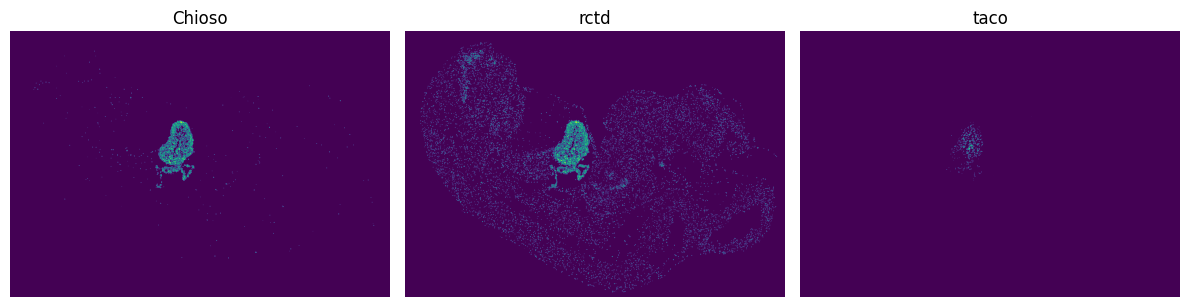

In [5]:
# visualize

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(pred_label == 8)
ax[0].set_title("Chioso")
ax[1].imshow(rctd_label == 8)
ax[1].set_title("rctd")
ax[2].imshow(tacco_label == 8)
ax[2].set_title("taco")
[a.axis('off') for a in ax]
plt.tight_layout()

## Comparing Chioso prediction with predictions from single-cell segmentation 

In [6]:
preds = [pred_cls, tacco_cls, rctd_cls, nn_cls]
m = np.zeros([4, 4])
for i, c1 in enumerate(preds):
    for j, c2 in enumerate(preds):
        m[i,j] = np.count_nonzero(c1 == c2) / len(c1)
print(m)        

[[1.         0.22367938 0.13697379 0.17302164]
 [0.22367938 1.         0.13247844 0.10726599]
 [0.13697379 0.13247844 1.         0.06717501]
 [0.17302164 0.10726599 0.06717501 1.        ]]


In [10]:
reject_rate = np.count_nonzero((rctd_df["spot_class"] == "reject") & (rctd_df["first_class"] >= 0))
reject_rate /= np.count_nonzero(rctd_df["first_class"] >= 0)
print(f"RCTD rejection rate : {reject_rate}")

RCTD rejection rate : 0.6881704670634902


#### Compute some metrics

Text(0.5, 1.0, 'Compare with TACCO')

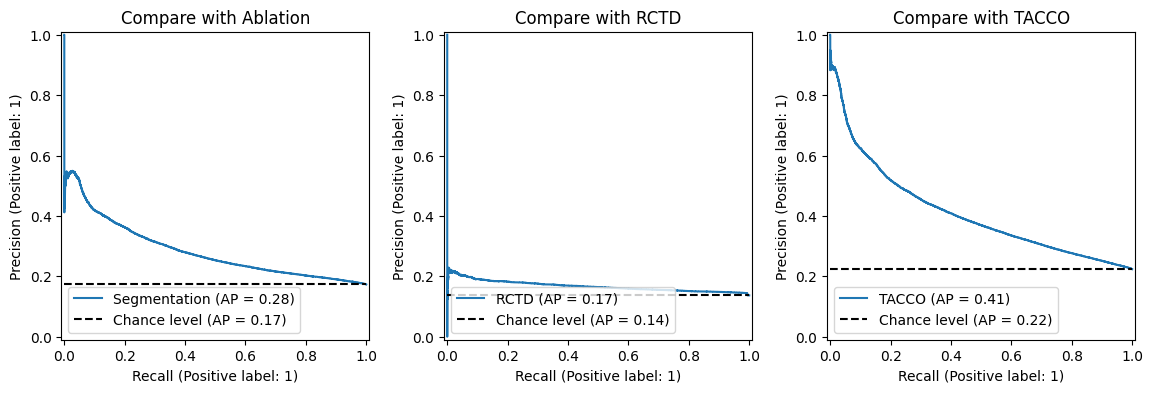

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

display = PrecisionRecallDisplay.from_predictions(
    nn_cls == pred_cls, nn_scores, name="Segmentation", plot_chance_level=True, ax=ax[0],
)
display.ax_.set_title("Compare with Ablation")

display = PrecisionRecallDisplay.from_predictions(
    rctd_cls == pred_cls, rctd_score, name="RCTD", plot_chance_level=True, ax=ax[1]
)
display.ax_.set_title("Compare with RCTD")

tacco_score = np.where(np.isnan(tacco_score), 0, tacco_score)
display = PrecisionRecallDisplay.from_predictions(
    tacco_cls == pred_cls, tacco_score, name="TACCO", plot_chance_level=True, ax=ax[2]
)
display.ax_.set_title("Compare with TACCO")

Text(0.5, 1.0, 'Compare with TACCO')

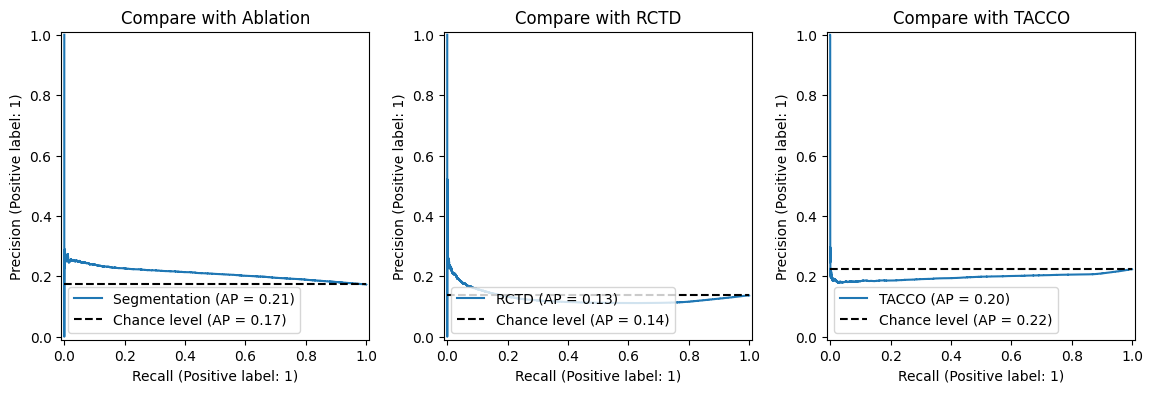

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

display = PrecisionRecallDisplay.from_predictions(
    nn_cls == pred_cls, pred_scores, name="Segmentation", plot_chance_level=True, ax=ax[0],
)
display.ax_.set_title("Compare with Ablation")

display = PrecisionRecallDisplay.from_predictions(
    rctd_cls == pred_cls, pred_scores, name="RCTD", plot_chance_level=True, ax=ax[1]
)
display.ax_.set_title("Compare with RCTD")

tacco_score = np.where(np.isnan(tacco_score), 0, tacco_score)
display = PrecisionRecallDisplay.from_predictions(
    tacco_cls == pred_cls, pred_scores, name="TACCO", plot_chance_level=True, ax=ax[2]
)
display.ax_.set_title("Compare with TACCO")

### Additional visulization

In [9]:
_names = np.array(sorted(list(cell_type_dict.keys())))

def show_cls_comparison(labels, sel, label=_names, seg=seg, cbar=cbar):
    fig, axs = plt.subplots(len(labels), len(sel), figsize=(25, 5*len(labels)))
    if axs.ndim == 1:
        axs = axs.reshape(1, -1)
    plt.subplots_adjust(left=0, right=1, top=.9, bottom=0, wspace=0, hspace=0.01)
    for row in range(len(labels)):
        for k, i in enumerate(sel):
            ax = axs[row, k]
            ax.imshow(seg[:,::-1].T, cmap='gray',  alpha=0.3)
            ax.imshow((labels[row][:, ::-1]==i+1).T, alpha=.8, cmap="gnuplot")
            ax.axis('off')
            if row == 0:
                ax.set_title(label[i], )
    return axs

def get_332_cmap(ncls):
    import matplotlib
    # cmap_i = np.round((np.arange(ncls+1))/(ncls+1) * 255).astype("uint8")
    cmap_i = np.arange(256)
    cmap_b = (cmap_i % 4)
    # cmap_b[1:] += 1
    cmap_b = cmap_b * 0x40 / 256
    cmap_g = ((cmap_i // 4) % 8) * 0x20 / 256
    cmap_r = (cmap_i // 32) * 0x20 /256
    sel = np.linspace(0, 255, ncls+1).astype(int)
    cmap_list = list(zip(cmap_r[sel], cmap_g[sel], cmap_b[sel]))
    cmap = matplotlib.colors.ListedColormap(cmap_list)
    return cmap

def show_label(labels, cls_label=_names):
    cmap = get_332_cmap(len(cls_label))
    n_imgs = len(labels)
    
    fig, ax = plt.subplots(1, n_imgs + 1, figsize=(5*n_imgs+2, 7), gridspec_kw={'width_ratios': [3]*n_imgs + [1]})

    for col in range(n_imgs):
        ax[col].imshow(labels[col][:,::-1].T, interpolation='nearest', cmap=cmap)
        ax[col].axis("off")
    
    ax[n_imgs].imshow((cbar+1)[:, None].repeat(10,axis=-1), vmin=0, interpolation='none', cmap=cmap)
    for k, name in enumerate(cls_label):
        ax[n_imgs].text(10, k+.35, name, fontsize=8)
    ax[n_imgs].axis('off')
    
    return ax

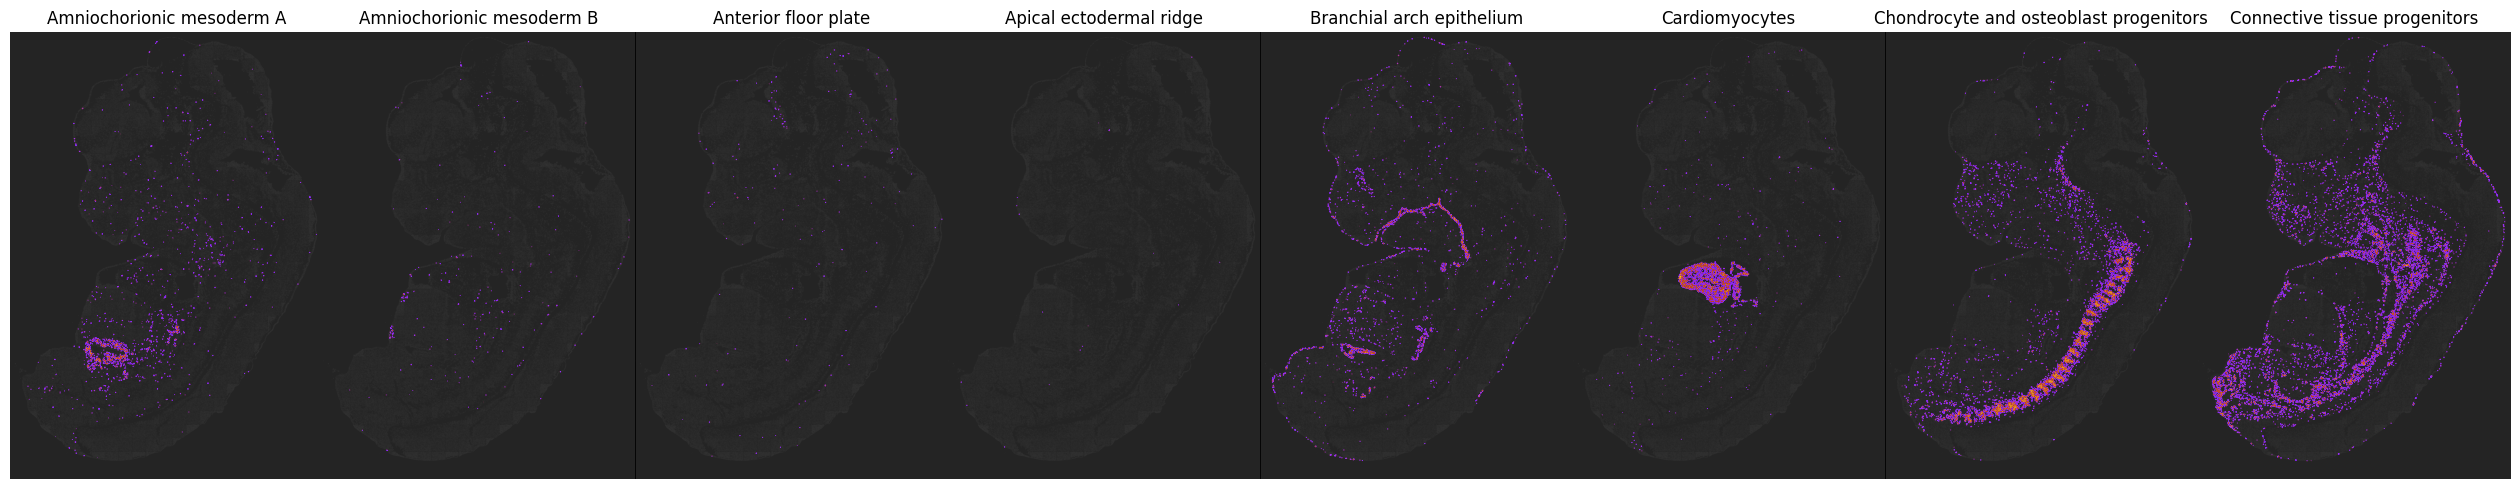

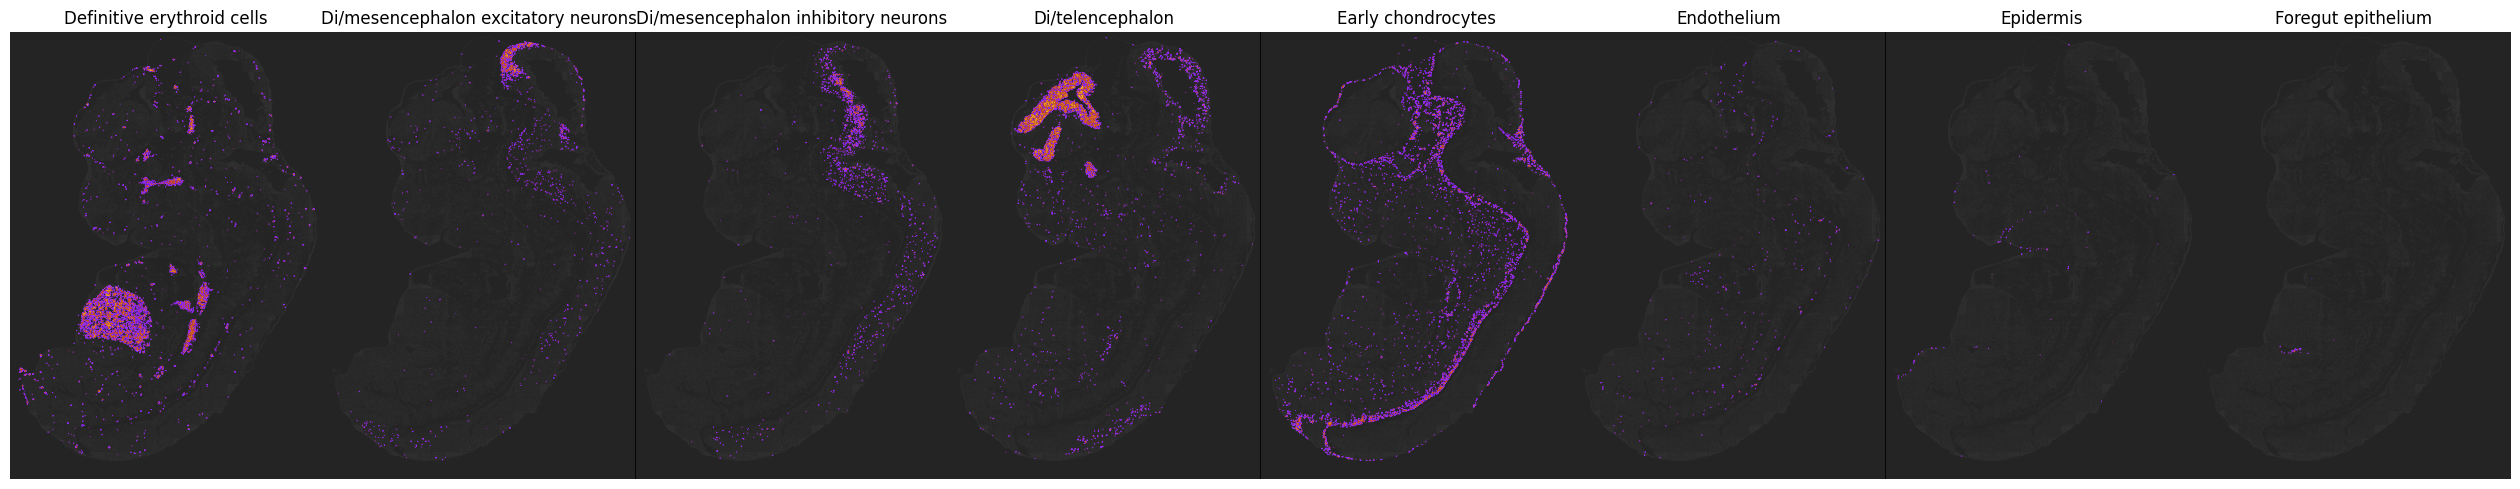

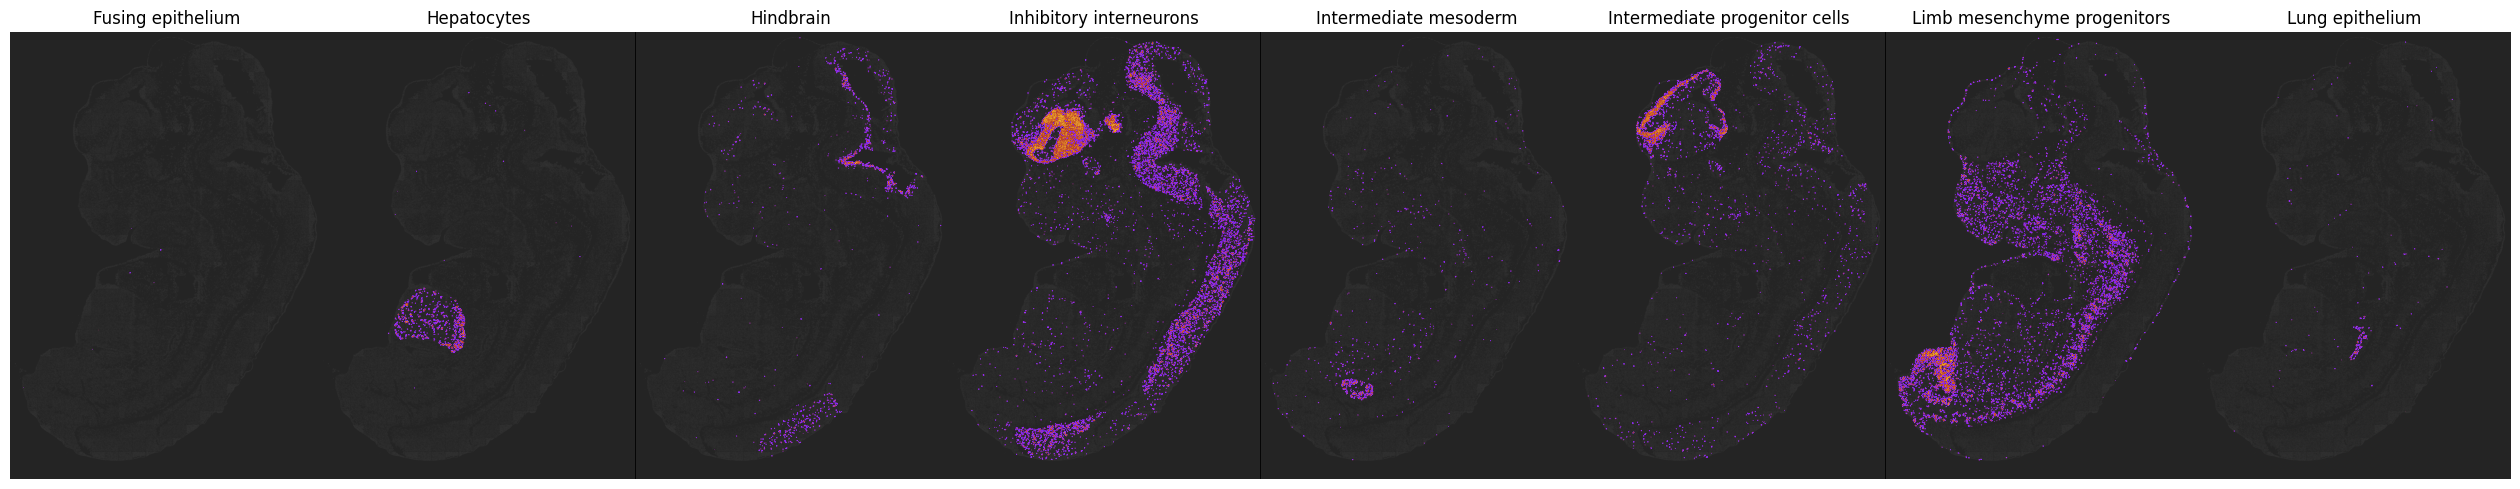

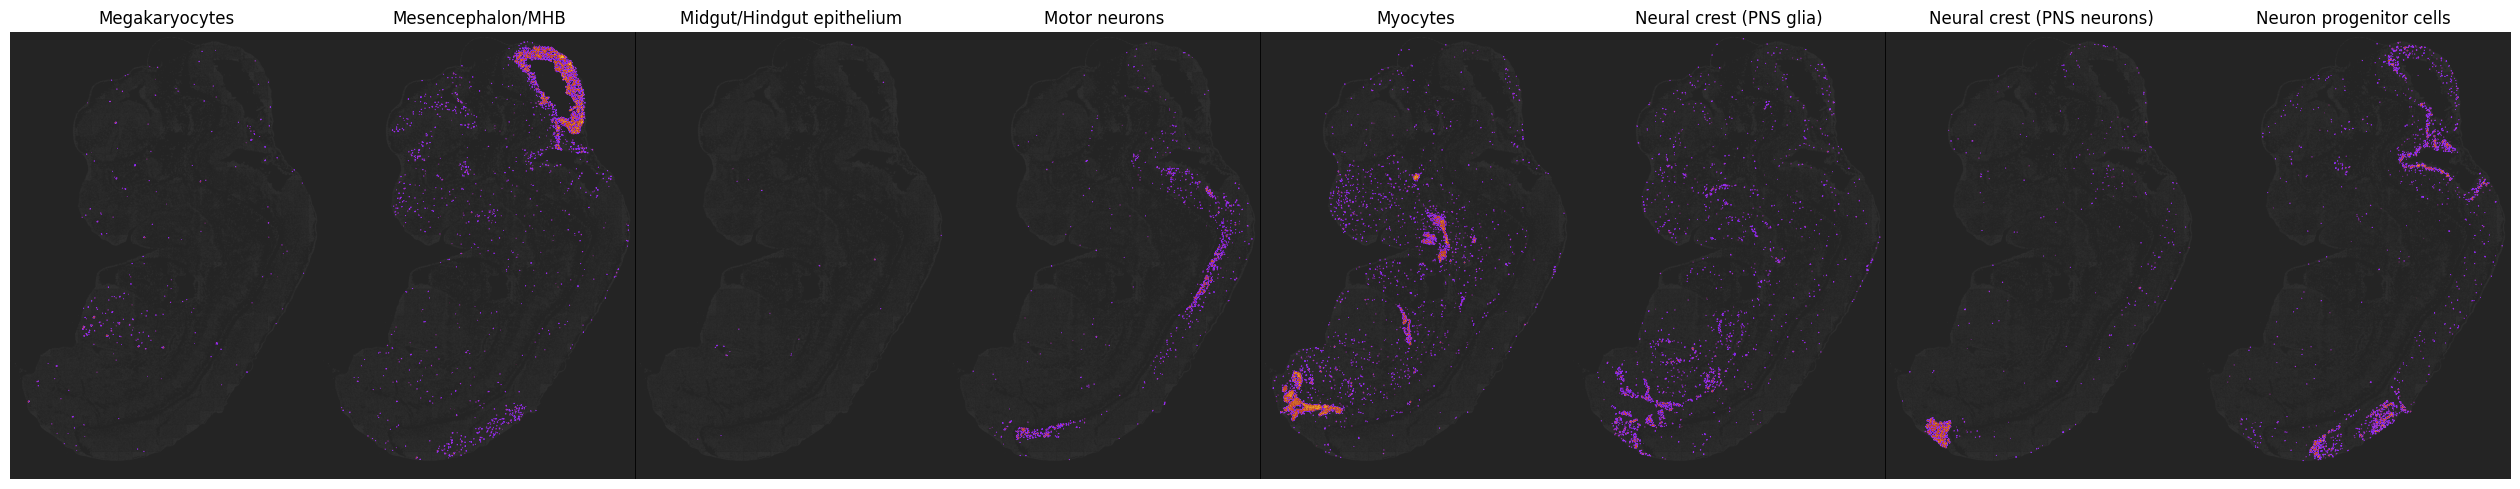

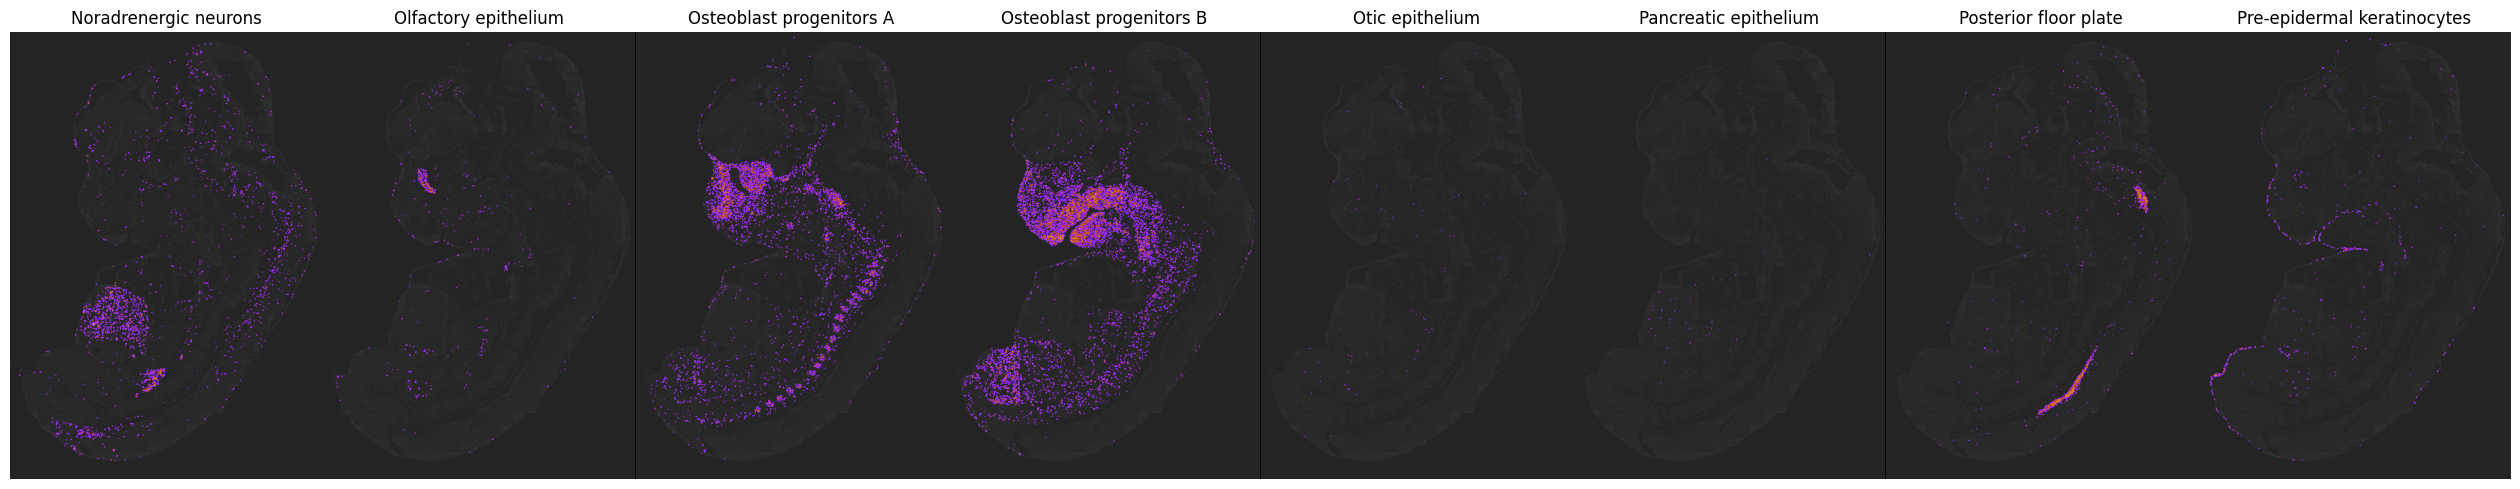

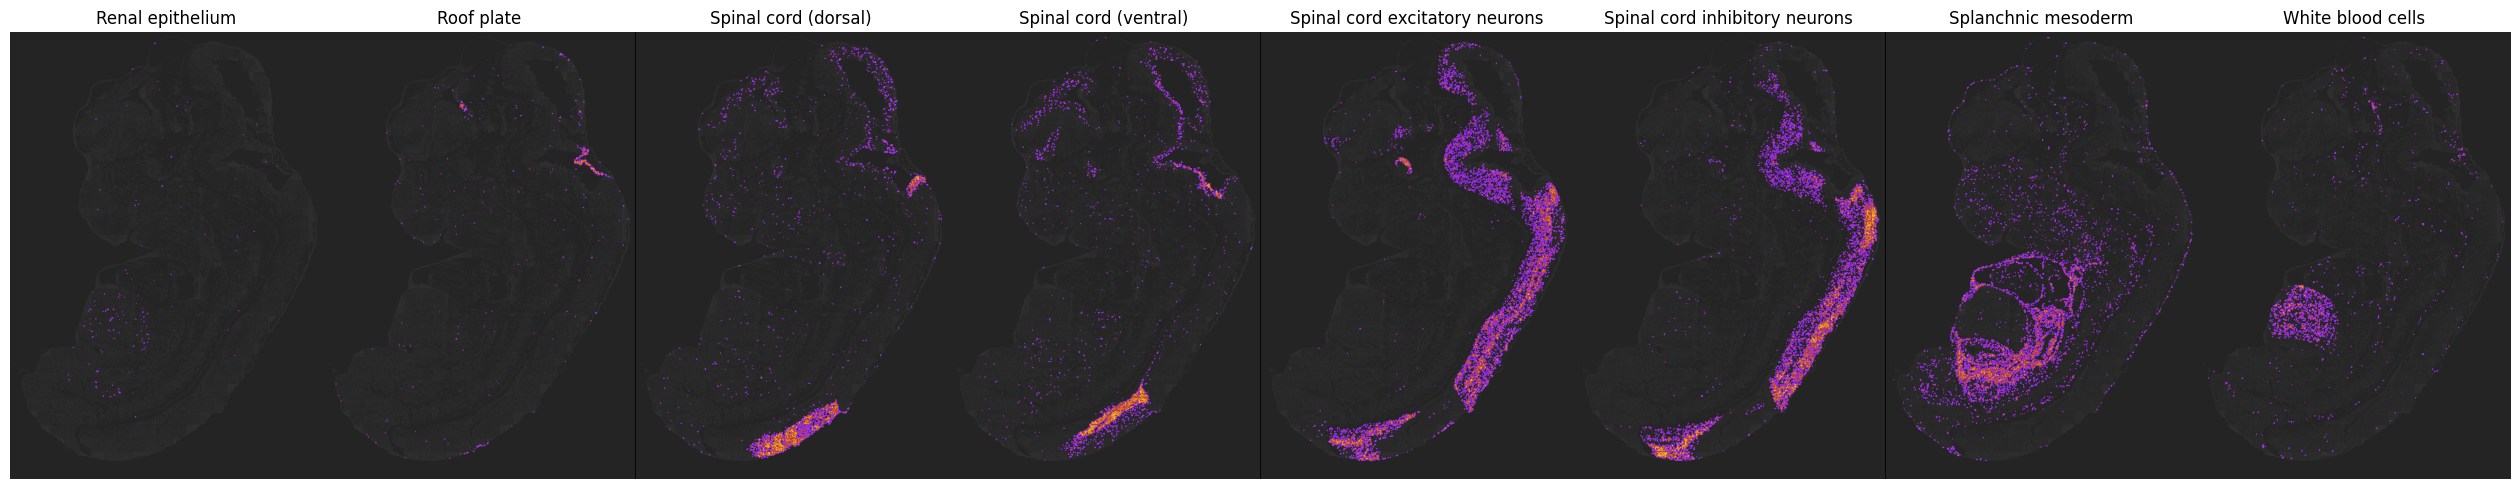

In [21]:
cbar_1 = np.array([ 0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 50, 51, 54, 58, 62, 63, 64, 65, 66, 67])

for k in range(0, len(cbar_1), 8):
    sel = cbar_1[k:k+8]
    if len(sel) < 8:
        sel = list(sel) + [-1] * (8-len(sel))
    axs = show_cls_comparison([pred_label], sel)

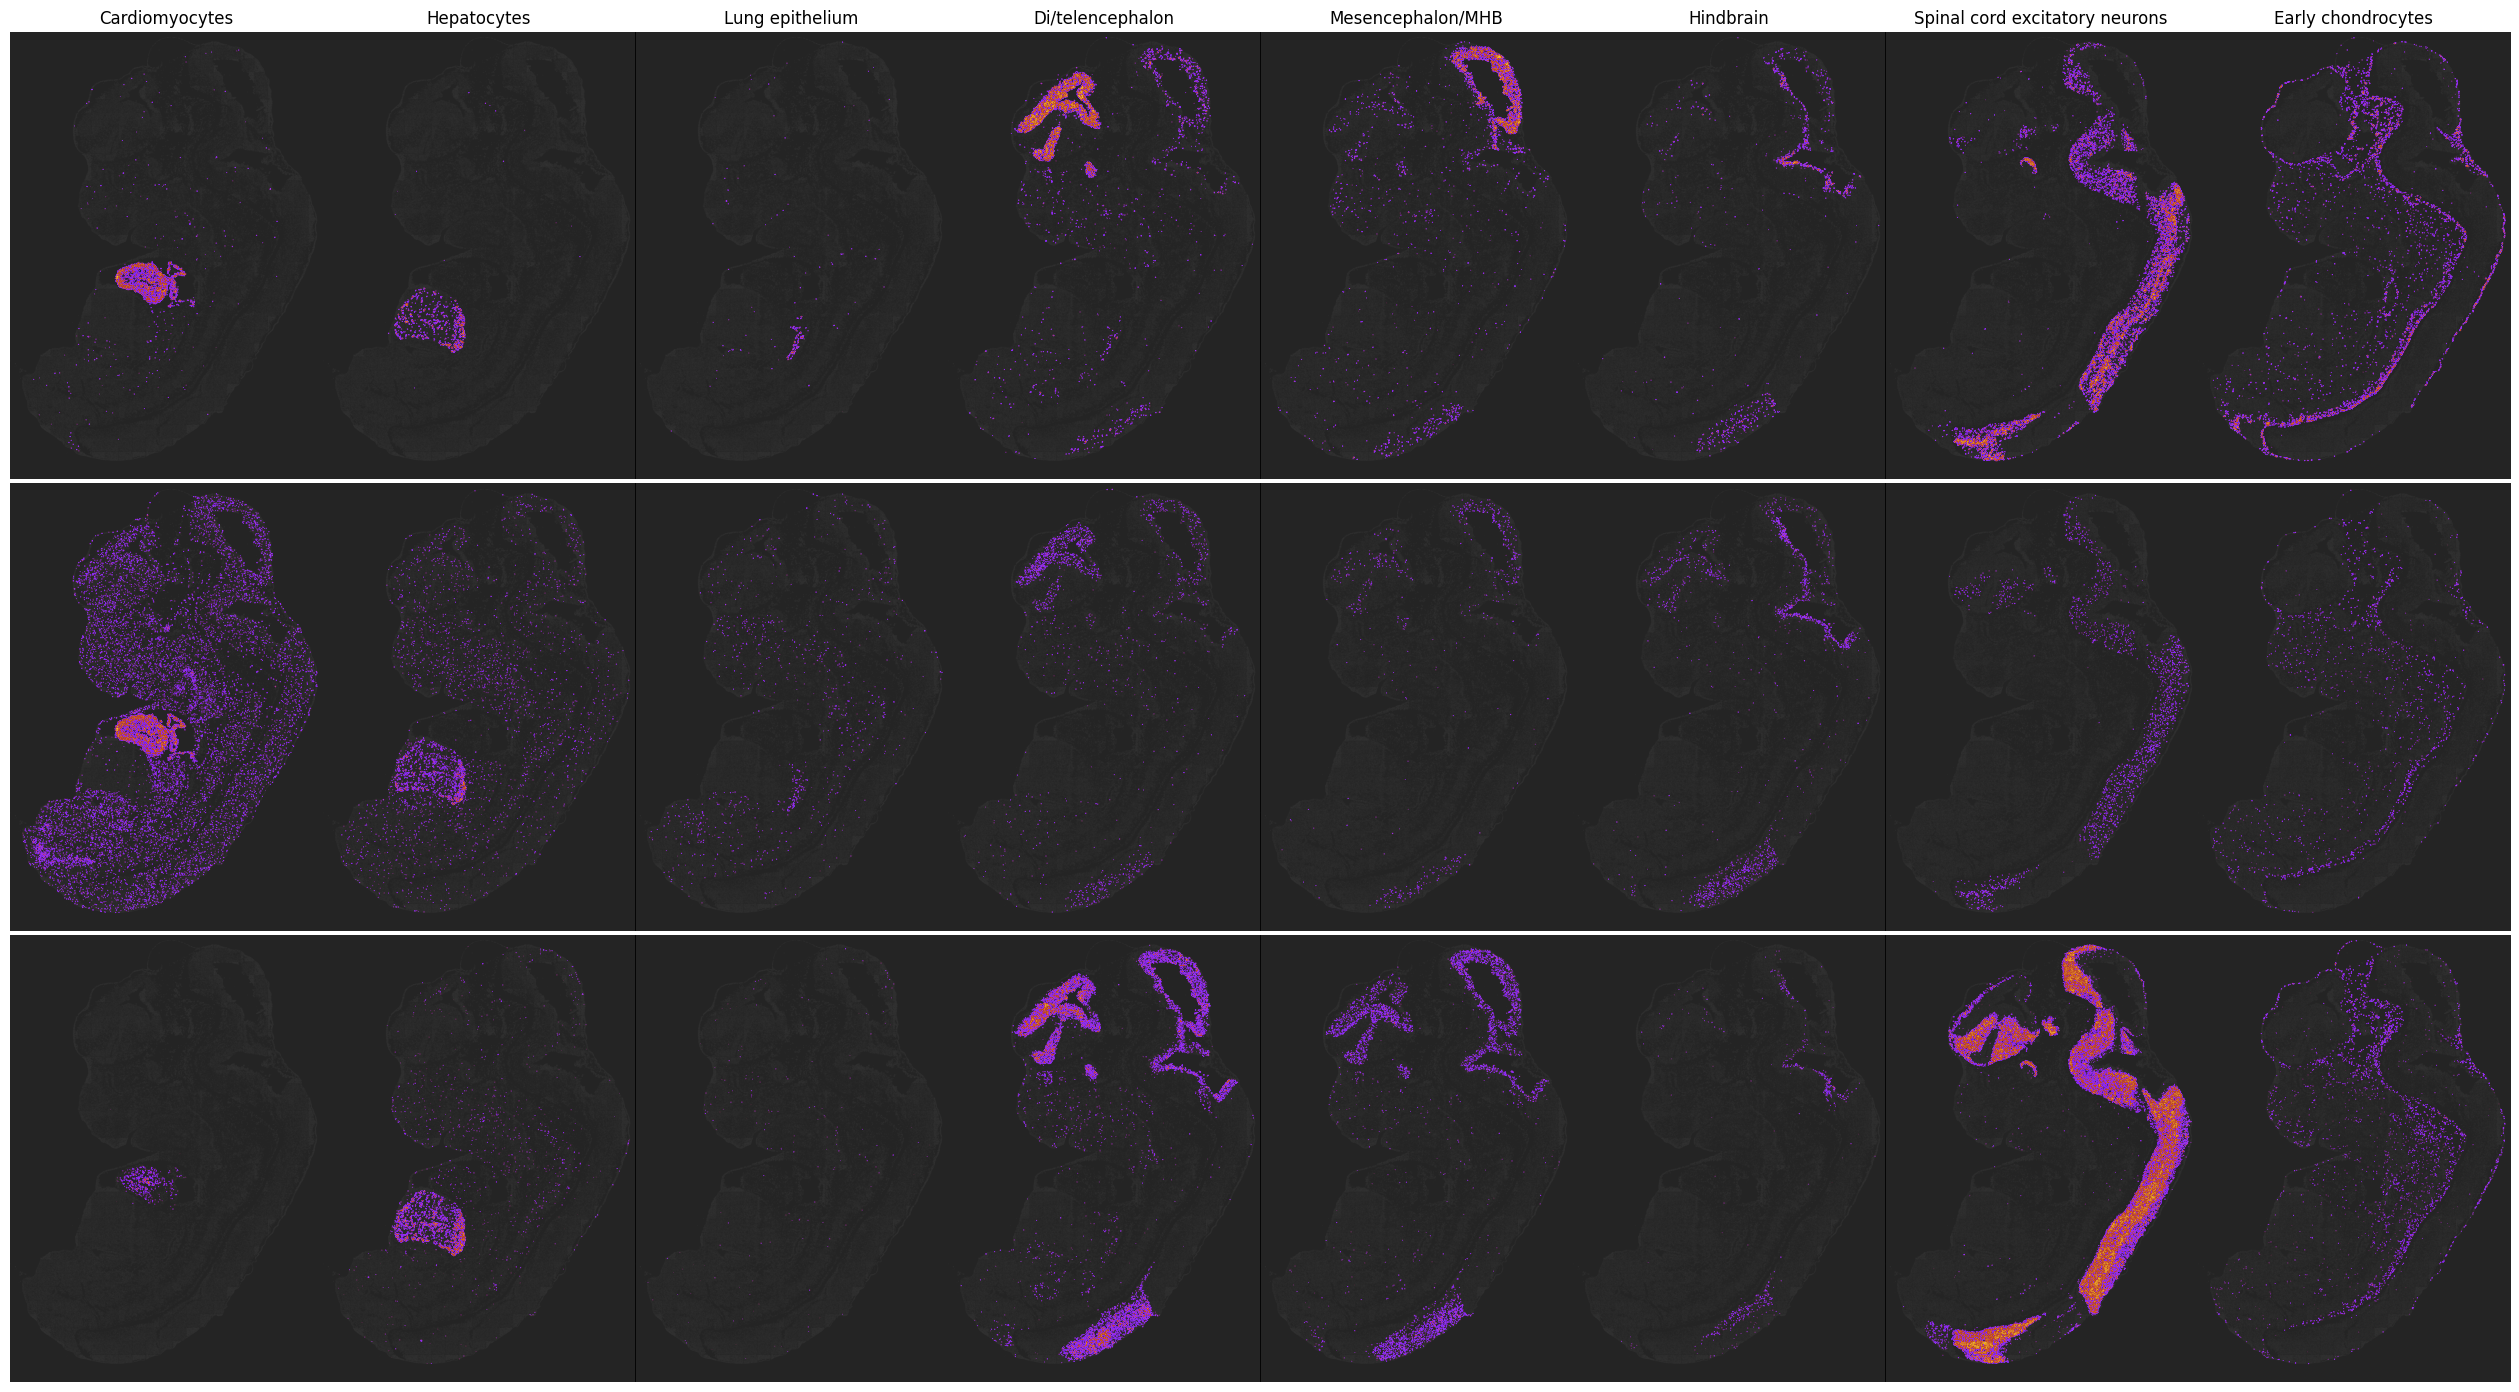

In [22]:
sel = [7, 23, 30, 13, 32, 24, 64, 14]
axs = show_cls_comparison([pred_label, rctd_label, tacco_label], sel)

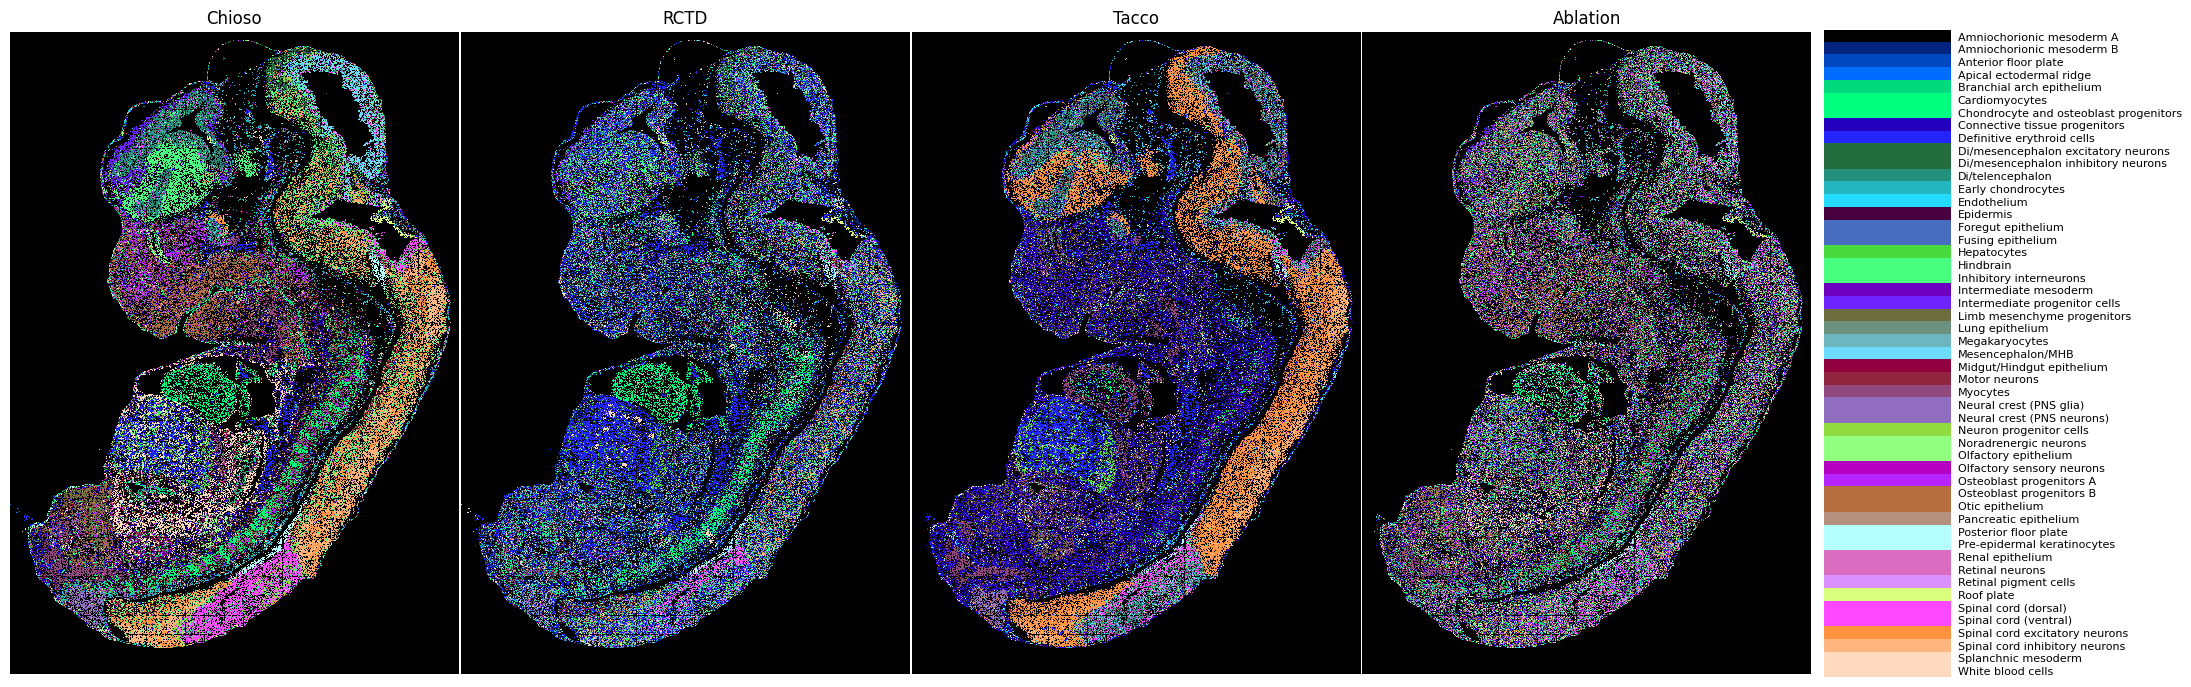

In [11]:
axs=show_label([pred_label, rctd_label, tacco_label, nn_label], np.array(sorted(list(cell_type_dict.keys())))[cbar])
axs[0].set_title("Chioso")
axs[1].set_title("RCTD")
axs[2].set_title("Tacco")
axs[3].set_title("Ablation")
plt.subplots_adjust(left=0.01)    
plt.tight_layout()

### Structure analysis

Perform outlier detection on each cell type: classifier each cell as either "normal" or "outlier" based on its location

This works well to detect wrong label if the celltype clump in a localized region (e.g. cardiomycyte), but is less useful for dispersed cells (e.g. red blood cell)

In [12]:
# compute cell centroids
sc = np.zeros([seg.max(), 2])
for rp in regionprops(seg):
    sc[rp.label-1] = rp.centroid
sc.shape

(223342, 2)

In [46]:
import pandas as pd
df0 = pd.DataFrame(dict(y=sc[:,0], x=sc[:,1], cls=pred_cls, method="chioso"))
df1 = pd.DataFrame(dict(y=sc[:,0], x=sc[:,1], cls=rctd_cls, method="rctd"))
df2 = pd.DataFrame(dict(y=sc[:,0], x=sc[:,1], cls=tacco_cls, method="tacco"))
df = pd.concat([df0, df1, df2])
df

y            x  cls  method
0        675.444444  3208.111111   27  chioso
1        693.615385   595.615385   28  chioso
2        494.750000   886.562500   44  chioso
3       1946.800000  1144.666667   50  chioso
4        145.000000  1026.000000   10  chioso
...             ...          ...  ...     ...
223337   827.000000  1043.000000   47   tacco
223338  2747.111111  2821.111111   14   tacco
223339  2585.666667  3018.333333    1   tacco
223340  2136.083333  2986.916667   24   tacco
223341  2041.875000  3267.875000   65   tacco

[670026 rows x 4 columns]

In [133]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from tqdm import tqdm

clf = IsolationForest()
df["score"] = 0.0
for t in tqdm(range(68)):
    sc_ = np.stack([df.loc[df.cls==t, "y"], df.loc[df.cls==t, "x"]], axis=-1)
    clf.fit(sc_)
    df.loc[df.cls==t, "score"] = clf.decision_function(sc_)
df.score = df.score > 0.05    

100%|██████████| 68/68 [00:12<00:00,  5.48it/s]


In [142]:
dfg = df.groupby(["method", "cls", "score"]).count().drop("x", axis=1).reset_index("score")
dfg = dfg.pivot(columns="score", values="y").rename({False: "outlier", True: "detections"}, axis=1)
dfg["outlier ratio"] = dfg.outlier / (dfg.outlier + dfg.detections)
dfg = dfg.reset_index("cls")
dfg = dfg.loc[dfg.cls<=68]
lut = np.array(sorted(list(cell_type_dict.keys())))
dfg["cls"] = lut[dfg.cls]
dfg

score                              cls  outlier  detections  outlier ratio
method                                                                    
chioso       Amniochorionic mesoderm A    769.0      1804.0       0.298873
chioso       Amniochorionic mesoderm B    215.0        77.0       0.736301
chioso            Anterior floor plate    200.0        33.0       0.858369
chioso         Apical ectodermal ridge     19.0         1.0       0.950000
chioso               Blood progenitors      4.0         8.0       0.333333
...                                ...      ...         ...            ...
tacco            Spinal cord (ventral)    484.0       944.0       0.338936
tacco   Spinal cord excitatory neurons  34037.0      5096.0       0.869777
tacco   Spinal cord inhibitory neurons   6951.0      1299.0       0.842545
tacco              Splanchnic mesoderm   1890.0      1062.0       0.640244
tacco                White blood cells   2614.0       470.0       0.847601

[170 rows x 4 columns]

In [143]:
dfg = dfg.loc[(dfg["cls"]==lut[7]) | (dfg["cls"]==lut[23]) |(dfg["cls"]==lut[30])  ]
dfg

score               cls  outlier  detections  outlier ratio
method                                                     
chioso   Cardiomyocytes    256.0      3223.0       0.073584
chioso      Hepatocytes     26.0      1547.0       0.016529
chioso  Lung epithelium     71.0       228.0       0.237458
rctd     Cardiomyocytes  10711.0      4479.0       0.705135
rctd        Hepatocytes   2275.0      1904.0       0.544389
rctd    Lung epithelium    726.0       191.0       0.791712
tacco    Cardiomyocytes      4.0       548.0       0.007246
tacco       Hepatocytes    952.0      2941.0       0.244541
tacco   Lung epithelium    179.0        21.0       0.895000

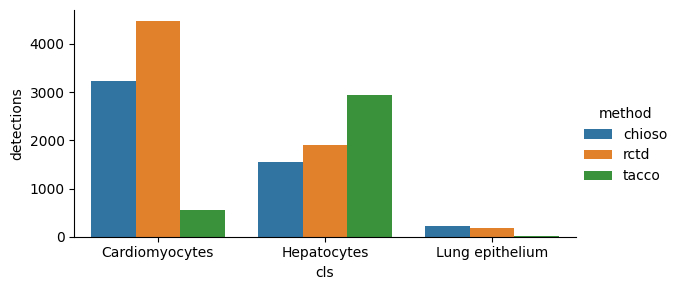

In [144]:
import seaborn as sns
sns.catplot(dfg, hue="method", x="cls", y="detections", kind="bar", height=3, aspect=2)

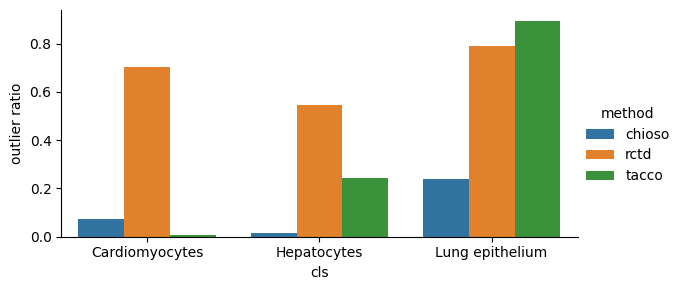

In [145]:
sns.catplot(dfg, hue="method", x="cls", y="outlier ratio", kind="bar", height=3, aspect=2)